In [1]:
import pickle as pk
import numpy as np
from glob import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
_size=41

In [3]:
data_dir="/dev/shm/data"
!mkdir $data_dir
#!rm $data_dir/patches*.npz
!rm $data_dir/*
!ls -lrt $data_dir/


mkdir: cannot create directory ‘/dev/shm/data’: File exists
rm: cannot remove '/dev/shm/data/*': No such file or directory
total 0


In [5]:
from os import system
def run(cmd):
    print('cmd=',cmd)
    system(cmd)

In [6]:
run('touch tmp')
!ls -l tmp

cmd= touch tmp
-rw-rw-r-- 1 ubuntu ubuntu 0 Oct 21 01:53 tmp


In [7]:
def read_file():
    s3files=!aws s3 ls $s3_dir/
    for file_i in range(len(s3files)):
        line=s3files[file_i]
        filename=line.split()[-1]
        !aws s3 cp $s3_dir/$filename $data_dir
        D=fromfile(data_dir+'/'+filename,dtype=np.float16)
        pics=D.reshape([-1,_size,_size])
        !rm $data_dir/$filename
        yield pics


In [8]:
def data_stream():
    for pics in read_file():
        for i in range(pics.shape[0]):
            yield pics[i,:,:]

In [38]:
pics_list=[]
i=0
for pic in data_stream():
    pics_list.append(np.array(pic,dtype=np.float32))
    i+=1
    if i>=500000:
        break

    
    

download: s3://mousebraindata-open/MD657/permuted/permuted0.bin to ../../../../dev/shm/data/permuted0.bin
download: s3://mousebraindata-open/MD657/permuted/permuted1.bin to ../../../../dev/shm/data/permuted1.bin
download: s3://mousebraindata-open/MD657/permuted/permuted10.bin to ../../../../dev/shm/data/permuted10.bin
download: s3://mousebraindata-open/MD657/permuted/permuted11.bin to ../../../../dev/shm/data/permuted11.bin


In [39]:
len(pics_list)

500000

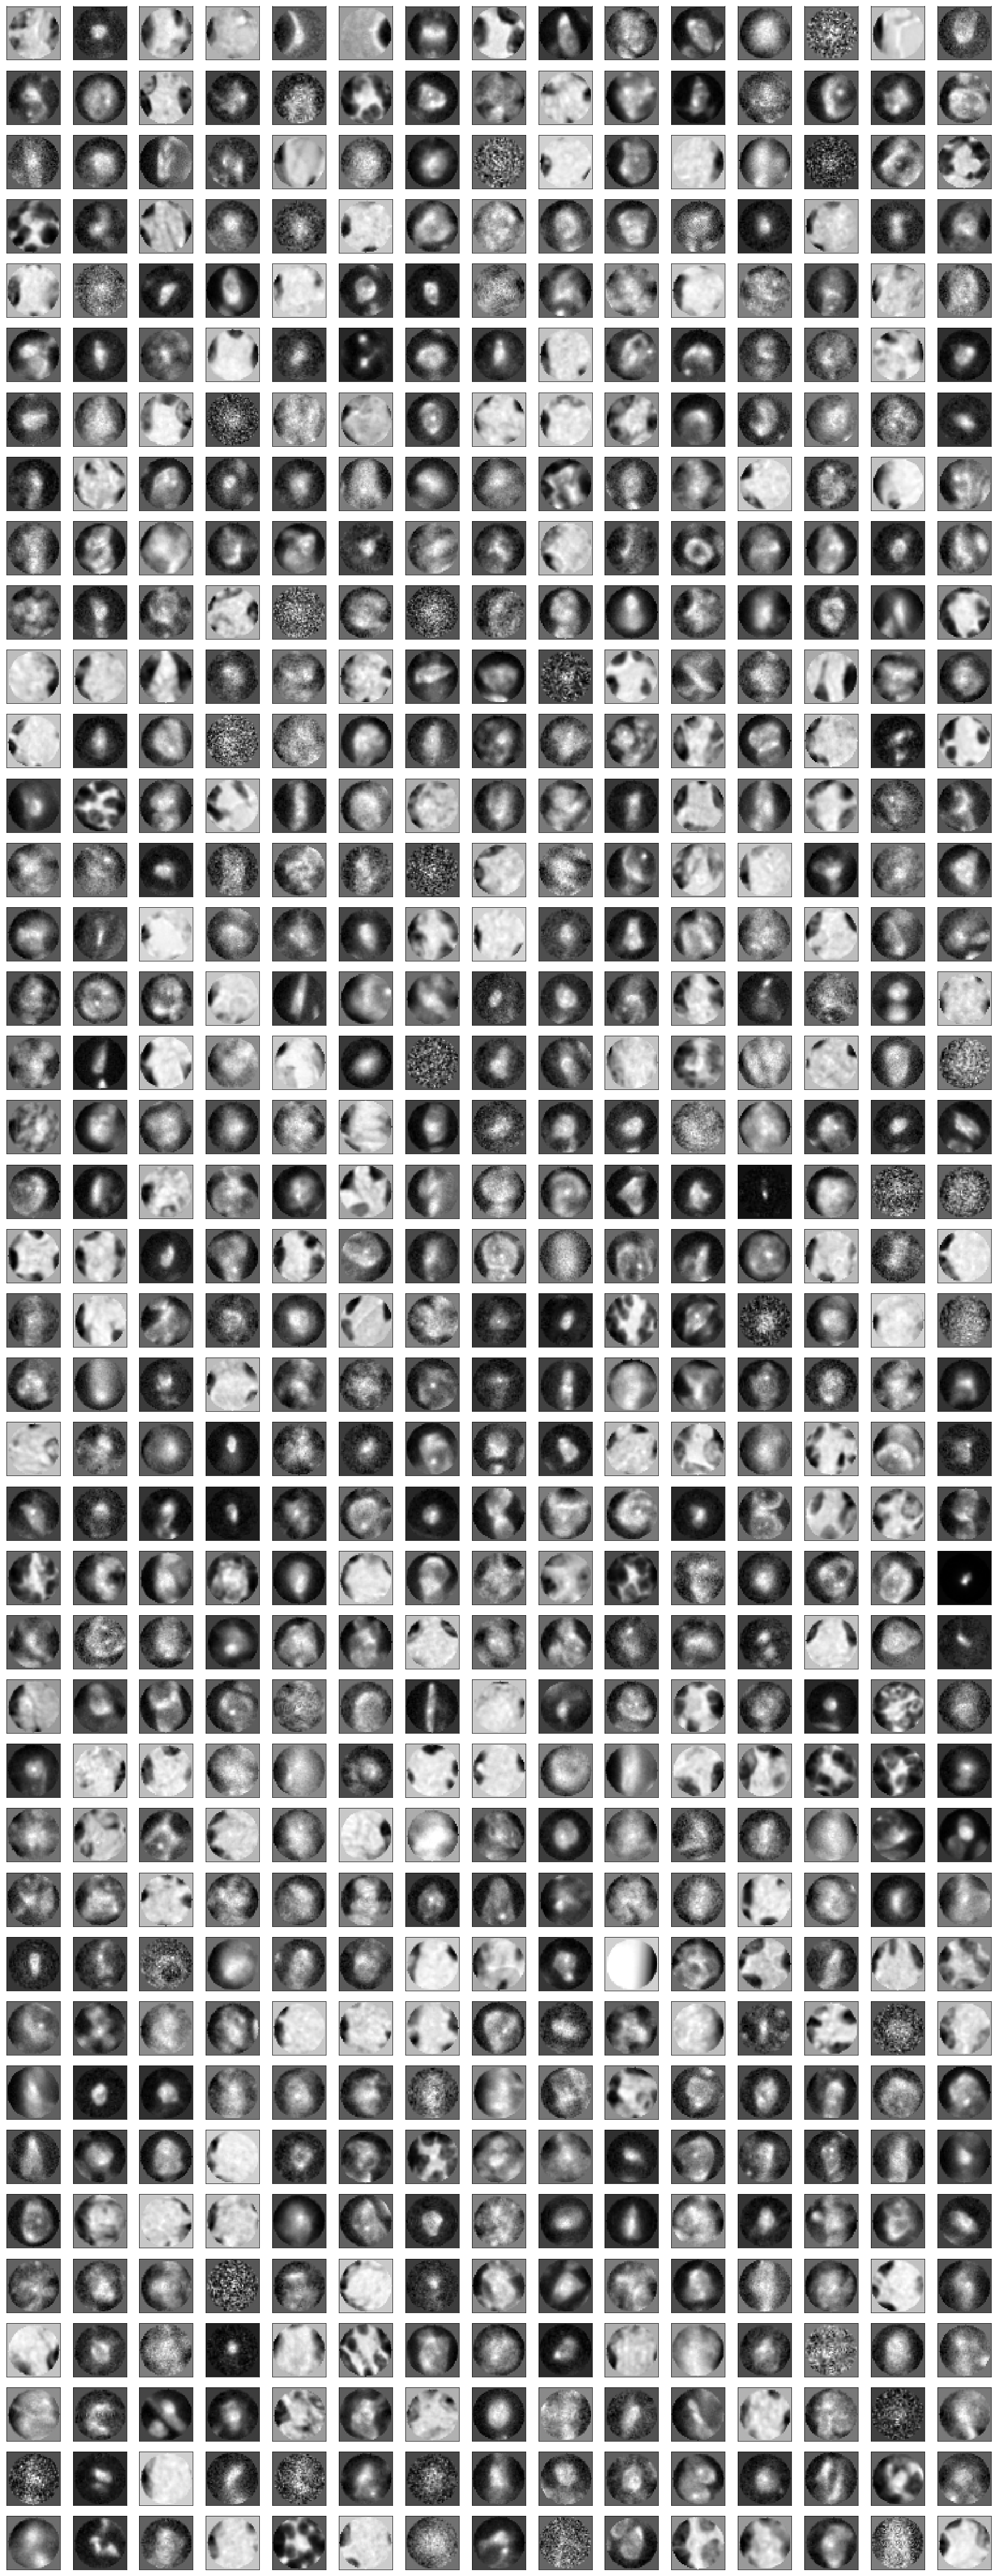

In [40]:
pics=pack_pics(pics_list)

plot_patches(pics)

In [41]:
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve
gaussian = Gaussian2DKernel(1,x_size=7,y_size=7)
factor=sum(gaussian)
print('factor=',factor)
def calc_err(pic):
    P=convolve(pic,gaussian)/factor
    error=sqrt(mean(abs(pic-P)))
    sub=P[::2,::2]
    return error,sub

factor= 0.9994587918263369


In [42]:
def plot_patches(data,h=40,w=15,_titles=[]):
    figure(figsize=(w*2,h*2))
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        subplot(h,w,i+1);
        pic=data[i,:,:]
        #P=convolve(pic,gaussian)/factor

        fig=imshow(pic,cmap='gray')
        if(len(_titles)>i):
            plt.title(_titles[i])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
#plot_patches(scombined,h=2,_titles=[str(i) for i in range(scombined.shape[0])])

In [ ]:
#collect images that are pretty smooth
# reduce resolution by a factor of 2
low_err=[]
for i in range(pics.shape[0]):
    pic=pics[i,:,:]
    error,sub=calc_err(pic)
    if error<0.3:
        low_err.append(sub)
        j=len(low_err)
        if j%1000==0:
            print('\r',i,j,end='')

lcombined=np.stack(low_err)
lcombined.shape

 196945 84000

In [23]:
def pack_pics(Reps):
    size=Reps[0].shape[0]
    _len=len(Reps)
    Reps_mat=np.zeros([_len,size,size])
    for i in range(_len):
        Reps_mat[i,:,:]=Reps[i]
    return Reps_mat

In [24]:
lcombined.shape

(4230, 21, 21)

In [25]:
def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

In [26]:
D=[]
for i in range(1,lcombined.shape[0]):
    D.append(dist2(lcombined[i,:,:],lcombined[i-1,:,:]))
    if i%1000==0:
        print('\r',i,end='')

 4000

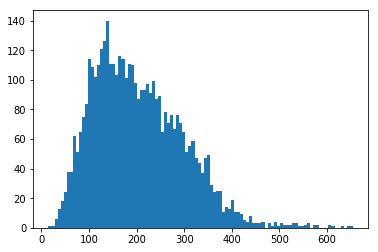

In [27]:
hist(D,bins=100);

In [28]:
max(D)

653.9629577499268

In [29]:
def refineKmeans(data,Reps):
    new_Reps=[np.zeros(Reps[0].shape) for r in Reps]
    Reps_count=[0.0 for r in Reps]
    error=0
    for i in range(data.shape[0]): 
        patch=data[i,:,:]
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
    error /= data.shape[0]
    final_Reps=[]
    final_counts=[]
    for i in range(len(new_Reps)):
        if Reps_count[i]>5:
            final_Reps.append(new_Reps[i]/Reps_count[i])
            final_counts.append(Reps_count[i])
    return final_Reps,final_counts,error

In [30]:
def Kmeans(data,n=100,scale=550):
    Reps,Statistics = Kmeanspp(data,n,scale)
    for i in range(5):
        Reps,error = refineKmeans(data,Reps)
        print('refine iteration %2d, error=%7.3f'%(i,error))

In [31]:
def Kmeanspp(data,n=100,scale=550):
    Reps=[data[0,:,:]]

    Statistics=[]
    j=1
    for i in range(1,data.shape[0]): 
        _min=100000
        patch=data[i,:,:]
        for r in Reps:
            _min=min(_min,dist2(patch,r))
        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f'%(i,len(Reps),Prob),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

In [32]:
def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

 i=       448,  #reps=        70  Prob=0.104207

 i=       660,  #reps=       104  Prob=0.102358

 i=      2396,  #reps=       299  Prob=0.132969

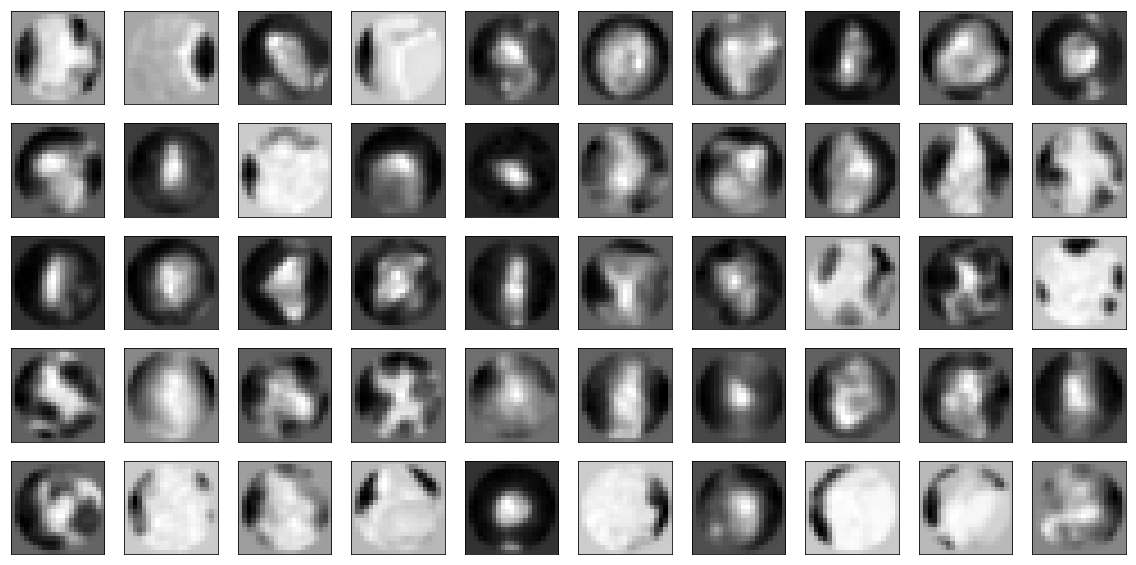

In [34]:
N=300

Reps, Statistics = Kmeanspp(lcombined,n=N)
Reps_mat = pack_pics(Reps)
plot_patches(Reps_mat,h=5,w=10)

In [35]:
Reps_mat.shape

(300, 21, 21)

In [37]:
for i in range(1,4):
    new_Reps,Reps_count,error = refineKmeans(lcombined[i*10000:(i+1)*10000,:,:],Reps)
    print(i,error,len(Reps_count))
    Reps_mat = pack_pics(new_Reps)
    plot_patches(Reps_mat,h=1,w=10,_titles=['%4d'%x for x in Reps_count])
    Reps=new_Reps
plot_patches(Reps_mat,h=10,w=10,_titles=['final_%4d'%x for x in Reps_count])

ZeroDivisionError: division by zero

## Calculate laplacian random-walk matrix

The matrix corresponds to a simple random walk on the individual examples  where the location of each example is replaced by the location of the corresponding representative. 

We use [pydiffmap](https://pydiffmap.readthedocs.io/en/master/)

In [39]:
L=len(new_Reps)
new_Reps[0].shape
data1D=np.concatenate([x.reshape([1,441]) for x in new_Reps])
data1D.shape

(234, 441)

Text(0.5,1,'distances between centroids')

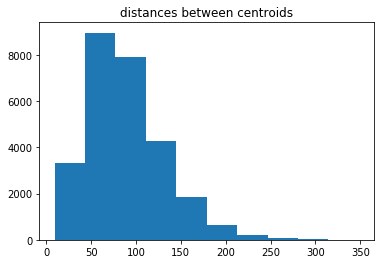

In [40]:
dists=[]
for i in range(L):
    for j in range(i):
        dists.append(dist2(new_Reps[i],new_Reps[j]))
hist(dists);
title('distances between centroids')

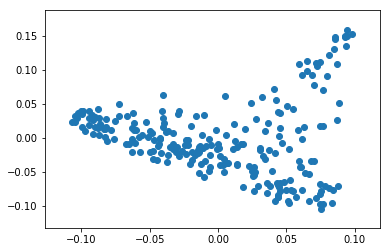

In [41]:
from pydiffmap import diffusion_map as dm
# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap(n_evecs=50, k=20, epsilon=100.0, alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(data1D)

#%pylab inline
pylab.scatter(dmap[:,0],dmap[:,1]);

Text(0.5,1,'no. of examples per partition')

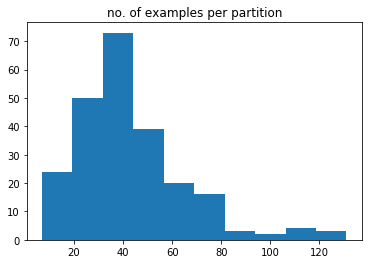

In [42]:
hist(Reps_count);
title('no. of examples per partition')

In [47]:
image_size=np.array(new_Reps[0].shape)
canvas_size=np.array([1000,1000])
_minx=min(dmap[:,0])
_maxx=max(dmap[:,0])
_miny=min(dmap[:,1])
_maxy=max(dmap[:,1])
shift_x = -_minx
scale_x = canvas_size[0]/(_maxx - _minx)
shift_y = -_miny
scale_y = canvas_size[1]/(_maxy - _miny)

x=[int((_x+shift_x)*scale_x) for _x in dmap[:,0]]
y=[int((_y+shift_y)*scale_y) for _y in dmap[:,1]]

canvas=2*np.ones(canvas_size+image_size)
for i in range(len(new_Reps)):
    if(Reps_count[i]>30):
        canvas[x[i]:x[i]+image_size[0],y[i]:y[i]+image_size[1]]=new_Reps[i]

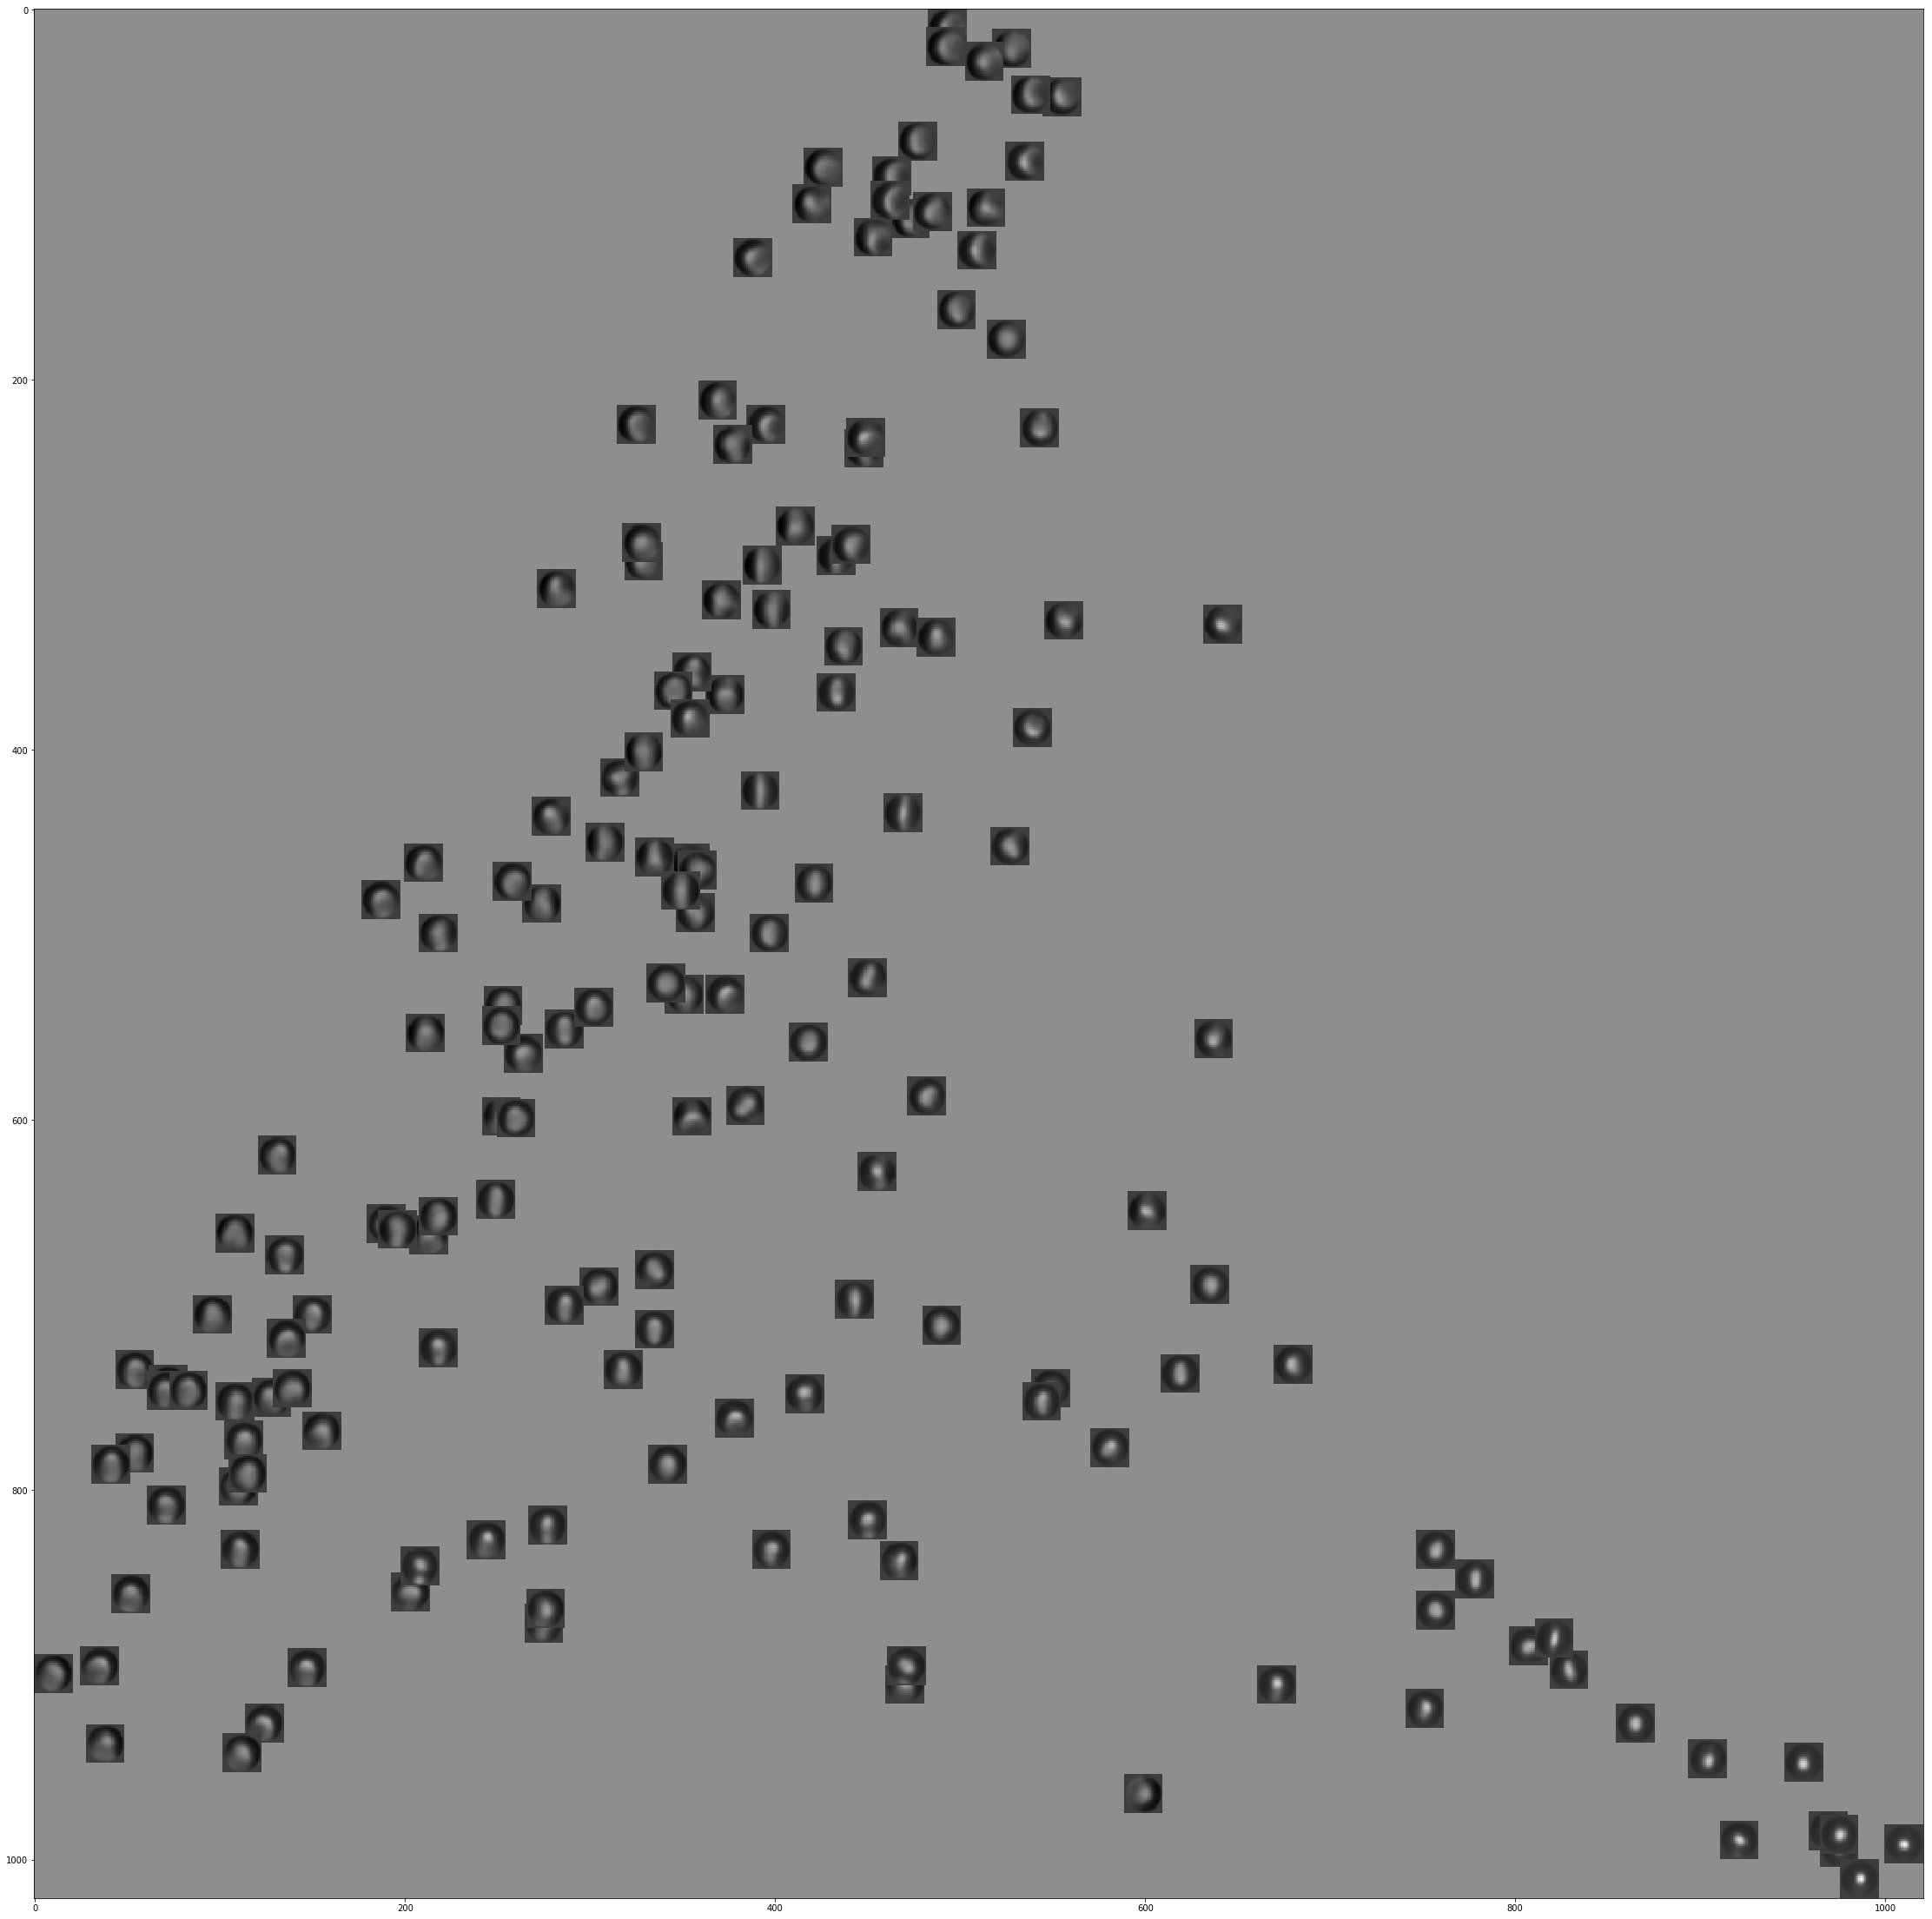

In [48]:
figure(figsize=[40,40])
imshow(canvas,cmap='gray')

In [462]:
max(new_Reps[0].flatten())

2.0300056627638945

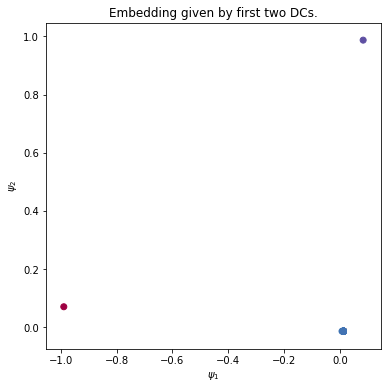

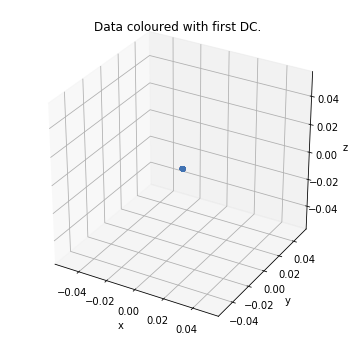

In [354]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()

In [308]:
A=np.zeros([L,L])
for i in range(L):
    for j in range(L):
        w=exp(-dist2(new_Reps[i],new_Reps[j])/sigma2)
        A[i,j]=w * Reps_count[i]*Reps_count[j]

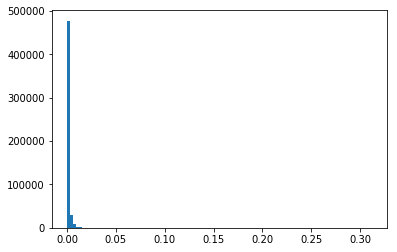

In [309]:
D=sum(A,axis=0)
D2=diag(1/sqrt(D))

NA=np.dot(D2,np.dot(A,D2))

w,v = np.linalg.eig(NA)
hist(NA.flatten(),bins=100);

eig no   0 eigval=1.000


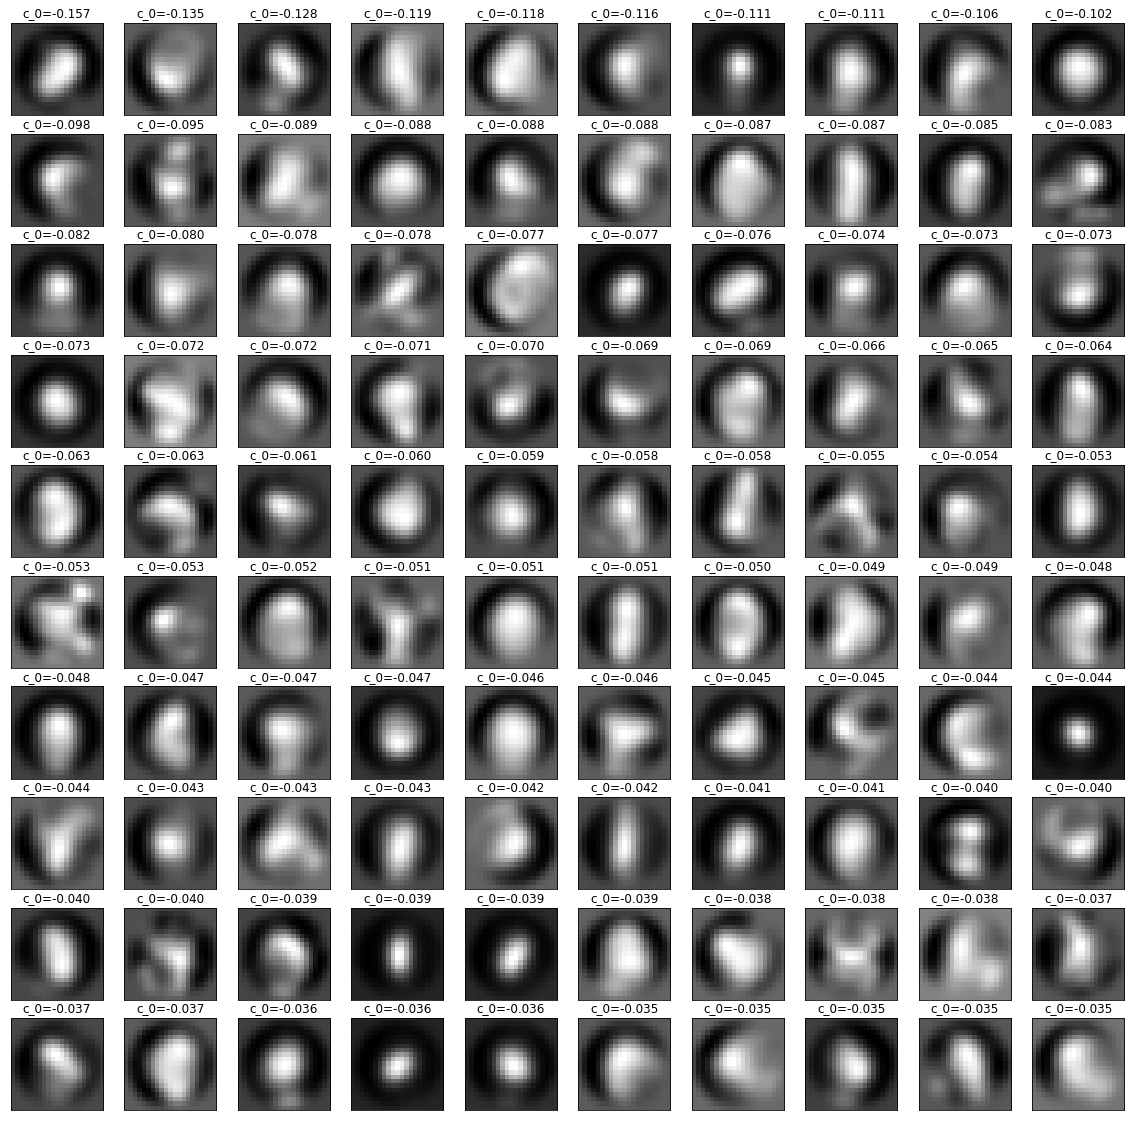

In [310]:
i=0
print('eig no %3d eigval=%5.3f'%(i,w[i]))
sorted_v=sort(v[i,:])
order=argsort(v[i,:])
plot_patches(Reps_mat[order],h=10,w=10,_titles=['c_%1d=%6.3f'%(i,x) for x in sorted_v])

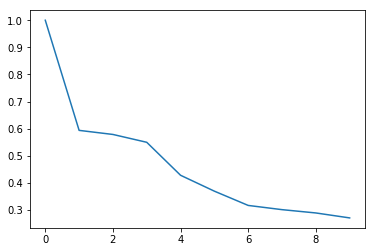

In [311]:
plot(w[:10])

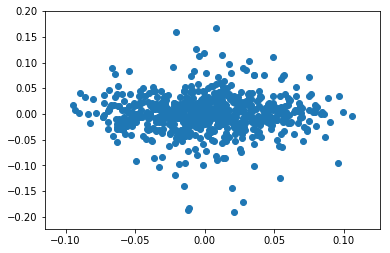

In [358]:
scatter(v[1,:],v[2,:])

array([ 0.0684984 , -0.09683269,  0.11339218, -0.02815852,  0.01356517,
        0.09702805, -0.00497052, -0.07564519, -0.00303605,  0.05598154,
       -0.02534961, -0.03255552,  0.25791296, -0.0872418 , -0.15506584,
        0.07946524,  0.11814611,  0.15164217,  0.23466678,  0.13819341,
       -0.14399507,  0.06415621,  0.07988999, -0.12789215,  0.08951426,
        0.15532145,  0.07016862,  0.15460653, -0.08454734, -0.14527753,
       -0.06276835,  0.1593729 , -0.13350627, -0.22839049,  0.01349753,
        0.23846752,  0.00080144,  0.20678977,  0.11093939,  0.12488391,
        0.01444126, -0.02112139,  0.05719365,  0.06418349, -0.223191  ,
       -0.0173864 ,  0.23103086,  0.28240511, -0.01096971,  0.01018806,
        0.02284379,  0.10457885, -0.05902885, -0.03521811, -0.006584  ,
        0.09166308,  0.0113964 , -0.00891202, -0.01769475, -0.01585222,
        0.03784947,  0.12000808,  0.07827504, -0.0363255 ,  0.02059863,
        0.21839337, -0.03755787, -0.00354101, -0.02926716, -0.01

In [185]:
v[2,:]

array([ 2.76030401e-02, -9.99369815e-01,  1.86132817e-02, -1.09338415e-02,
        1.96145234e-03, -2.14331499e-03, -8.98918520e-04,  1.85929501e-03,
        1.50086424e-03,  6.09601482e-04,  2.05811280e-03, -8.29983576e-04,
       -2.32679127e-03, -7.05417265e-04,  5.70638293e-05,  3.19153459e-04,
        2.21861093e-04, -1.49317035e-04,  3.95528026e-04, -5.57342638e-04,
       -1.30430651e-03, -4.68911652e-04, -1.96314600e-04, -6.01913609e-04,
       -1.81860647e-04, -1.19399305e-03, -6.41843880e-05, -1.20281315e-03])